In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

from src.helpers import get_FD_matrix, calculate_relgap
from src.experiments import study_approximation_convergence

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Read/build the matrices

In [3]:
# orani678 = sp.io.mmread('data/orani678.mtx').tocsc()
# bcspwr10 = sp.io.mmread('data/bcspwr10.mtx').tocsc()
# gr_30_30 = sps.csc_matrix(sp.io.mmread('data/gr_30_30.mtx').toarray().astype(np.float64))  # NOTE: Stored as int
# helm2d03 = sp.io.mmread('data/helm2d03.mtx').tocsc()

In [4]:
# fd_1d = get_FD_matrix(n=4096, d=1)
# fd_2d = get_FD_matrix(n=64, d=2)
# fd_3d = get_FD_matrix(n=16, d=3)

## Analyze the matrices

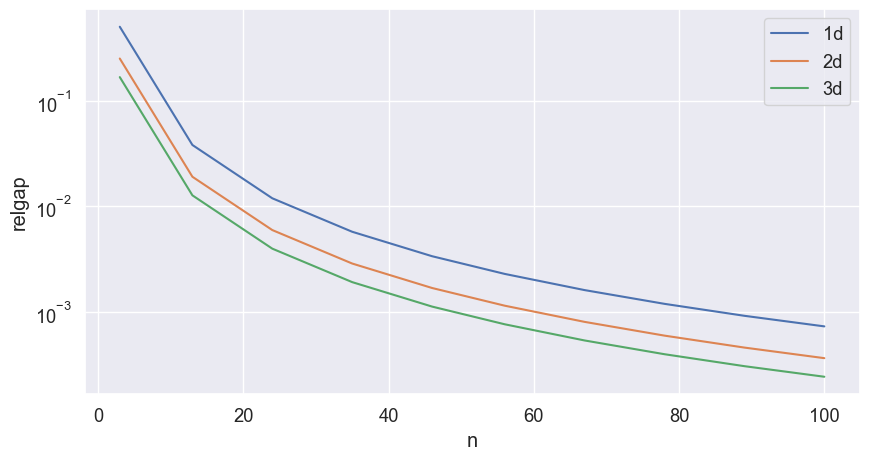

In [6]:
# Relative gap decreases as n gets bigger

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for d in [1, 2, 3]:
    ns = []
    eigs = []
    for n in np.linspace(3, 100, 10):
        n = int(n)
        ns.append(n)
        eigs.append(calculate_relgap(get_FD_matrix(n=n, d=d)))

    sns.lineplot(x=ns, y=eigs, ax=ax, label=f'{d}d')

ax.set(yscale='log', ylabel='relgap', xlabel='n')
ax.legend()

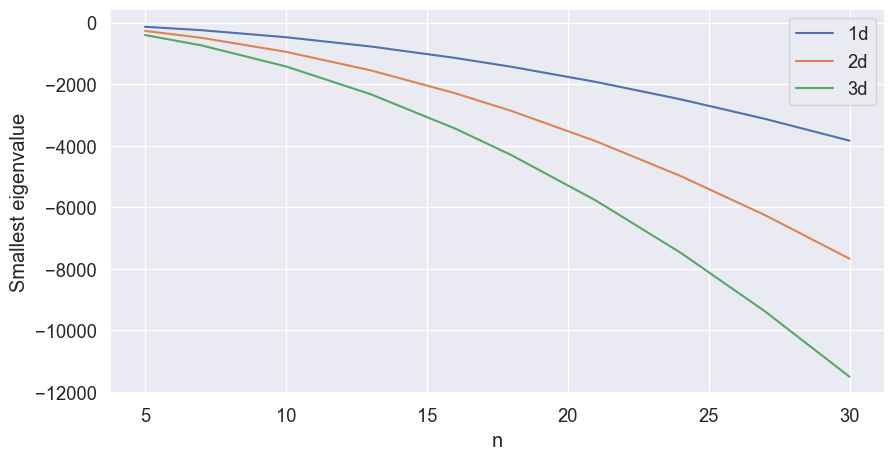

In [25]:
# NOTE: smallest eigenvalue > - (n+1)^2 * (12)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for d in [1, 2, 3]:
    ns = []
    eigs = []
    for n in np.linspace(5, 30, 10):
        n = int(n)
        ns.append(n)
        eigs.append(float(sps.linalg.eigsh(get_FD_matrix(n=n, d=d), k=1, which='SA')[0]))

    sns.lineplot(x=ns, y=eigs, ax=ax, label=f'{d}d')

ax.set(ylabel='Smallest eigenvalue', xlabel='n')
ax.legend()

# $\varphi$-function approximation

## Problem for matrices with large values

In [7]:
from src.phi import Phi

<Axes: >

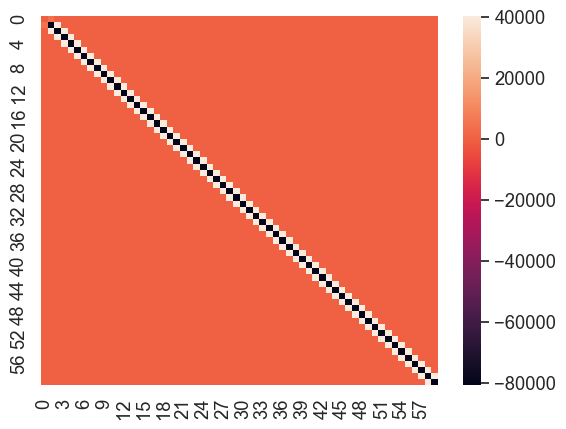

In [8]:
A = get_FD_matrix(n=200, d=1)
v = np.ones(shape=A.shape[0], dtype=A.dtype)
V_m, H_m = Phi.arnoldi(A=A, v=v, m=60)
sns.heatmap(pd.DataFrame(H_m))

When trying to calculate the $\exp(\hat{H}_m)$, overflow happens in `scipy.linalg.expm()`. Somewhere in their algorithm, they compute $\cosh(0.5 \sqrt{(a_1-a_4)^2 + 4 a_2 a_3})$ for $2 \times 2$ submatrices. The largest representable value by `float64` is $2^{1024} \simeq e^{700}$.

> Suddenly solved by itself !!

# Convergence results for $\varphi(tA)v$

In [9]:
results = {}

## `fd_1d_nnnn` with `m_exact<=1000`

In [ ]:
n_ = 500

A = get_FD_matrix(n=n_, d=1)
t = 1 / (n_ + 1)
name = f'fd_1d_{n_:04d}'
name_ = f'fd\_1d\_{n_:04d}'
n = A.shape[0]
v = np.ones(shape=n, dtype=A.dtype)

results[name] = study_approximation_convergence(
    A=(t * A),
    v=v,
    ps=range(5),
    ms=[int(m) for m in np.linspace(5, 400, 30)],
    title='$A={%s}$; $v=[1\:1\:\cdots\:1]^T$' % (name_),
    m_exact=400,
)


## `fd_2d_nnnn` with `m_exact=300`

In [ ]:
n_ = 100
A = get_FD_matrix(n=n_, d=2)
t = 1 / (n_ + 1)
name = f'fd_2d_{n_:04d}'
name_ = f'fd\_2d\_{n_:04d}'
n = A.shape[0]
v = np.ones(shape=n, dtype=A.dtype)

results[name] = study_approximation_convergence(
    A=(t * A),
    v=v,
    ps=range(5),
    ms=[int(m) for m in np.linspace(5, 200, 30)],
    title='$A={%s}$; $v=[1\:1\:\cdots\:1]^T$' % (name_),
    # m_exact=300,
)


# Comparing convergence of matrices

## Compare matrices with different `n`

In [37]:
def compare_convergences(dfs: list[pd.DataFrame], ps: list[int], title: str = None):
    g = sns.FacetGrid(
        data=pd.concat([pd.concat([df[df['$p$'] == p] for p in ps]) for df in dfs]),
        col='$p$',
        hue='$A =$',
        col_wrap=2,
        height=5,
        aspect=1.5,
    )
    g.map(sns.lineplot, '$m$', 'Relative error')
    g.add_legend()
    g.set(yscale='log', ylim=[1e-14, 1e+01], xlim=[0, 200])
    if title:
        plt.title(title)
    return g

In [30]:
for name, df in results.items():
    df['$A =$'] = '$' + name.replace('_', '\_') + '$'

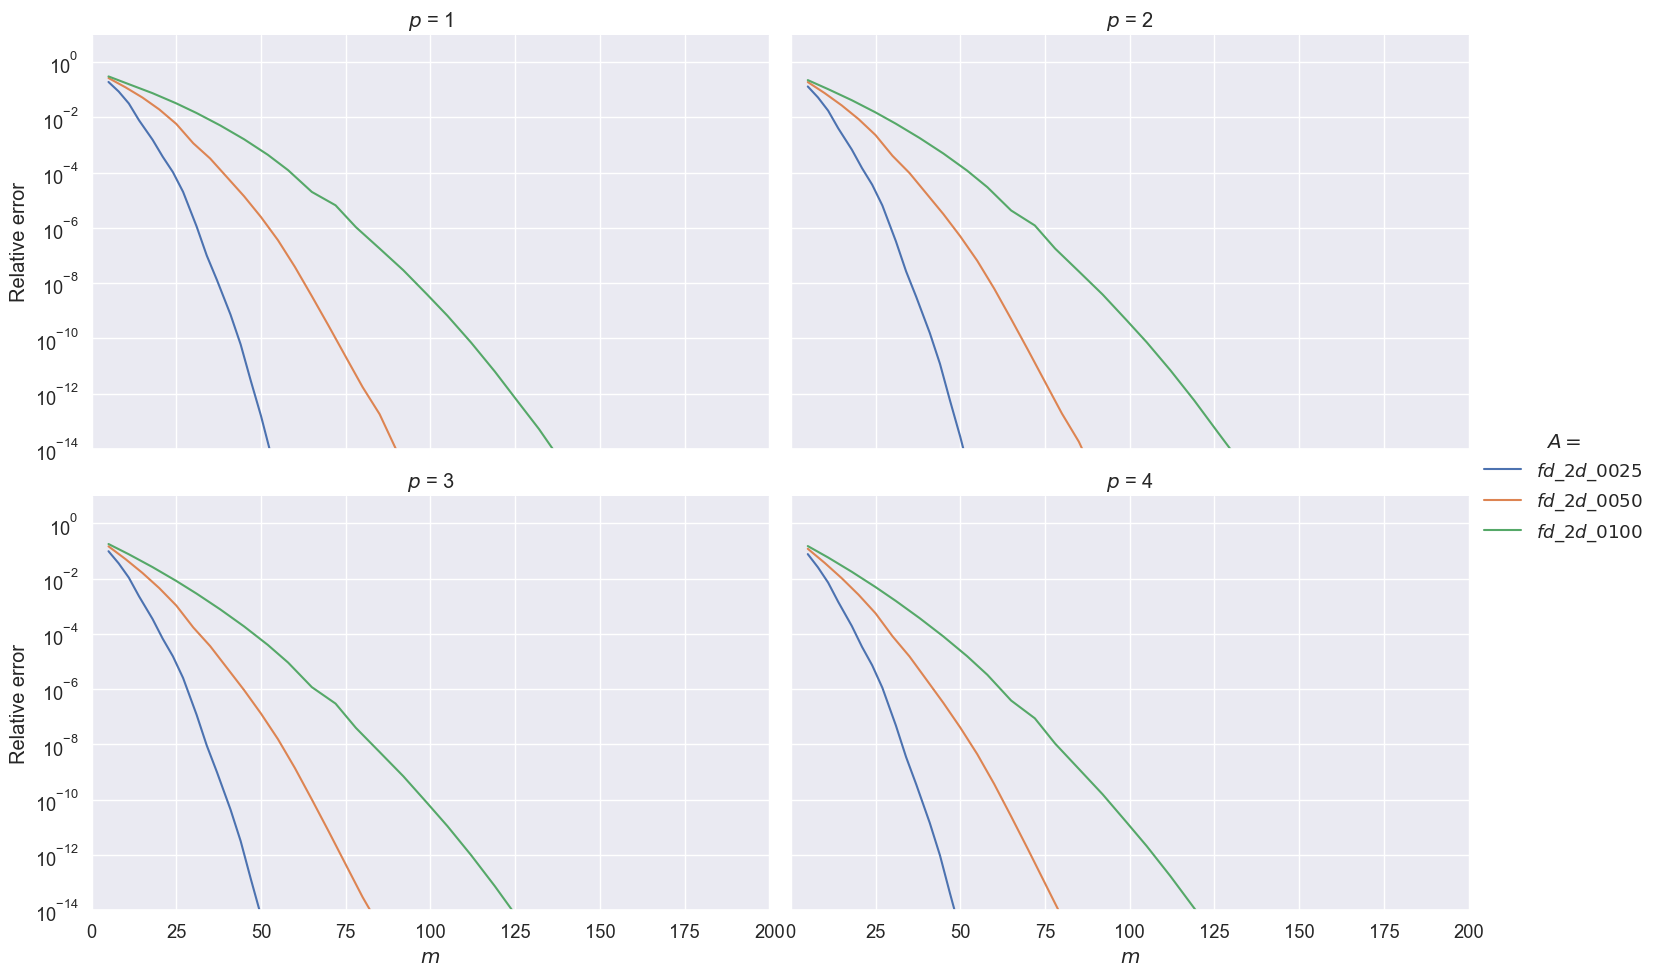

In [38]:
ps=[1, 2, 3, 4]
g = compare_convergences(
    dfs=[
        results['fd_2d_0025'],
        results['fd_2d_0050'],
        results['fd_2d_0100'],
    ],
    ps=ps,
)

## Compare with error estimations

In [100]:
def get_errors_taylor(ps, ms, n=2000, alpha=8):
    """
    Assumes the vector v is ones of size n.
    """

    ms = np.array([int(m) for m in ms])
    dfs = []
    for p in ps:
        bound = (2 * np.sqrt(n) * (alpha ** ms)
                / np.array([np.math.factorial(m + p) for m in ms], dtype=np.float64))

        dfs.append(
            pd.DataFrame({
                '$p$': [p] * len(ms),
                '$m$': ms,
                '$A =$': 'Estimate #1',
                'Relative error': bound,
            })
        )

    return pd.concat(dfs)

In [89]:
def get_errors_chebyshev(ps, ms, n=2000, alpha=8):
    """
    Assumes the vector v is ones of size n.
    estimates for p!=1 are not valid.
    """

    dfs = []
    for p in ps:
        bound_i = (
            np.sqrt(n) * (5 * (alpha ** 2)) / (ms ** 3)
            * np.exp(- 4 * (ms ** 2) / (5 * alpha))
        )
        bound = (
            np.sqrt(n) * 64 / (12 * ms - 5 * alpha)
            * ((np.e * alpha / (4 * ms + 2 * alpha)) ** ms)
        )
        bound[np.where(ms < (alpha / 2))] = bound_i[np.where(ms < (alpha / 2))]
        # bound[np.where(ms < np.sqrt(alpha))] = np.nan

        dfs.append(
            pd.DataFrame({
                '$p$': [p] * len(ms),
                '$m$': ms,
                '$A =$': 'Estimate #2',
                'Relative error': bound,
            })
        )

    return pd.concat(dfs)

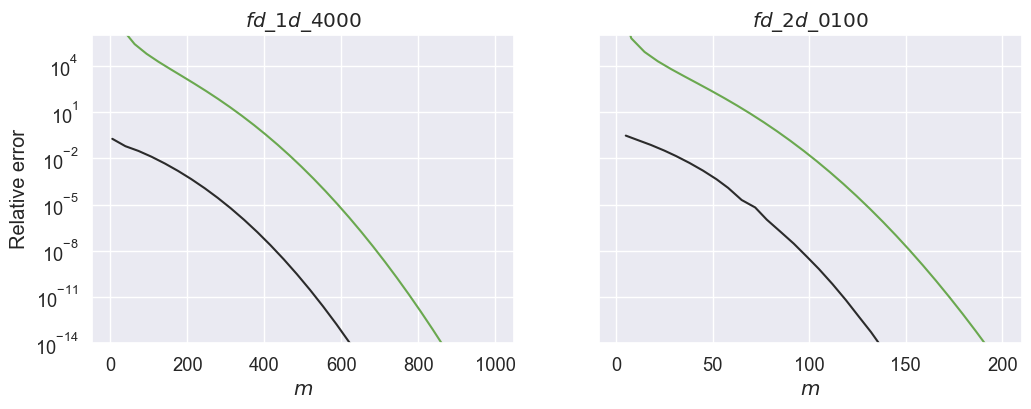

In [102]:
p = 1
df1 = pd.concat([
    results['fd_1d_4000'][results['fd_1d_4000']['$p$'] == p].copy(),
    # get_errors_taylor(ps=ps, ms=np.linspace(1, 800, 30), n=4000, alpha=(4001 * 4)),
    get_errors_chebyshev(ps=[p], ms=np.linspace(1, 900, 30), n=4000, alpha=(4001 * 4))
])
df2 = pd.concat([
    results['fd_2d_0100'][results['fd_2d_0100']['$p$'] == p].copy(),
    # get_errors_taylor(ps=ps, ms=np.linspace(1, 200, 30), n=10000, alpha=(101 * 8)),
    get_errors_chebyshev(ps=[p], ms=np.linspace(1, 200, 30), n=10000, alpha=(101 * 8))
])

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.lineplot(
    data=df1,
    hue='$A =$',
    x='$m$',
    y='Relative error',
    ax=axs[0],
    palette=['#2b2b2b', '#6aa84f'],
)
sns.lineplot(
    data=df2,
    x='$m$',
    y='Relative error',
    hue='$A =$',
    ax=axs[1],
    palette=['#2b2b2b', '#6aa84f'],
)
axs[0].set(yscale='log', title='$fd\_1d\_4000$', ylim=[1e-14, 1e+06])
axs[1].set(yscale='log', title='$fd\_2d\_0100$', ylim=[1e-14, 1e+06])
for ax in axs:
    ax.get_legend().remove()